In [1]:
import torch
from load_data import *

In [2]:
device = torch.device('cuda:0')

# LoadDataset

In [4]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_adult_data()
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

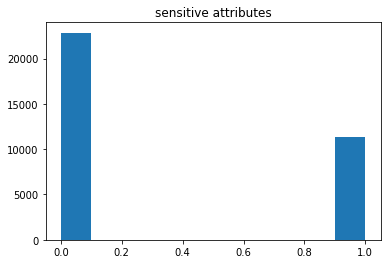

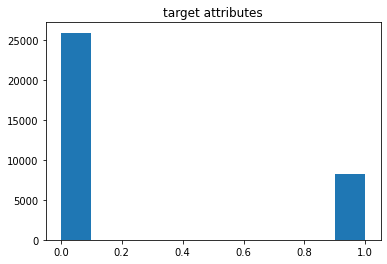

In [5]:
import matplotlib.pyplot as plt
plt.hist(Ztr[:,0])
plt.title("sensitive attributes")
plt.show()
plt.hist(ytr)
plt.title("target attributes")
plt.show()

In [6]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training default: ", sum(ytr==0)/len(ytr))
print("test default: ", sum(yte==0)/len(yte))
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)
print('# output vars', ytr.shape)

sensitive ratio:  [0.66846062]
training default:  [0.75977654]
test default:  [0.76291544]
# training samples: (34189, 55)
# test samples: (14653, 55)
# sensitive vars (34189, 1)
# output vars (34189, 1)


In [7]:
N1 = 300
Xtr1 = Xtr[:N1]
ytr1 = ytr[:N1]
Ztr1 = Ztr[:N1]
Xtr2 = Xtr[N1:]
ytr2 = ytr[N1:]
Ztr2 = Ztr[N1:]

In [8]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training init: ", sum(ytr1==0)/len(ytr1))
print("select init: ", sum(ytr2==0)/len(ytr2))
print("test default: ", sum(yte==0)/len(yte))

sensitive ratio:  [0.66846062]
training init:  [0.795]
select init:  [0.75956927]
test default:  [0.76291544]


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
from fairNN_train import *
from load_data import *
from fair_eval import *

In [11]:
class Args:
    def __init__(self):
        self.epochs = 50
#         self.max_epochs = None
        self.AL_iters = 10 # AL batch 몇 번 뽑는지?
        self.AL_batch = 32 # AL 시에 select 되는 데이터 수
        self.batch_size = 64
        self.AL_select = 'acc'
        self.num_classes = 2
#         self.AL_valid = 32
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [12]:
args = Args()

In [13]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=False)

In [14]:
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [15]:
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [16]:
from fairAL_utils import *

In [17]:
n_features = train_data.tensors[0].shape[1]
clf = Classifier(n_features=n_features)
clf.to(device)

Classifier(
  (network): Sequential(
    (0): Linear(in_features=55, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

## compute gradient

In [19]:
clf.eval()

Classifier(
  (network): Sequential(
    (0): Linear(in_features=55, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

- adversarial example jacobiab: https://github.com/ast0414/adversarial-example/blob/master/craft.py
- https://github.com/HIPS/autograd
- https://gist.github.com/sbarratt/37356c46ad1350d4c30aefbd488a4faa 

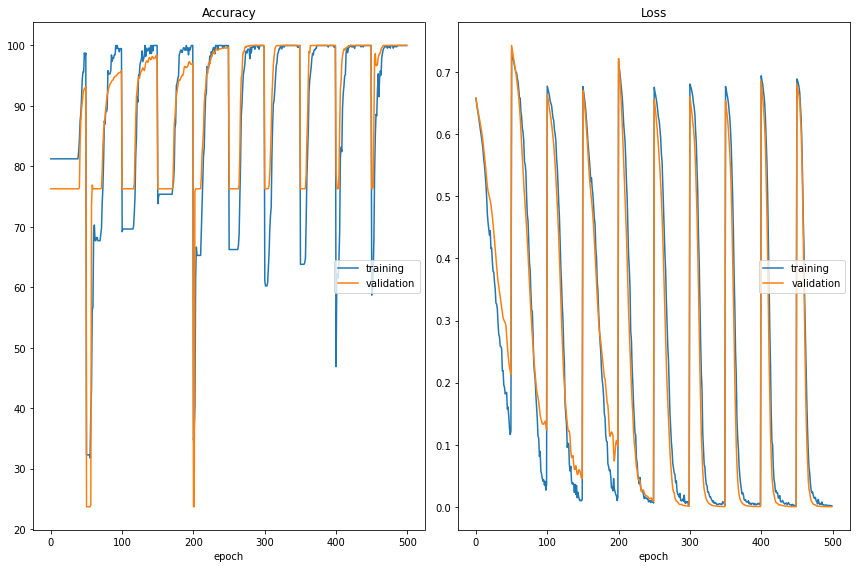

Accuracy
	training         	 (min:   31.771, max:  100.000, cur:  100.000)
	validation       	 (min:   23.708, max:  100.000, cur:  100.000)
Loss
	training         	 (min:    0.001, max:    0.733, cur:    0.002)
	validation       	 (min:    0.000, max:    0.743, cur:    0.000)
Finished Training


In [20]:
clf,f_train,f_select = train_AL_valid(train_loader, select_loader, device, args, test_loader, clf_type = 'NN',\
                                      from_scratch = True, sel_method = 'entropy',val_ratio = 0.2)

In [21]:
clf_criterion = nn.BCELoss()
print("test performances")
test_groupwise(clf,test_loader, clf_criterion, device,args)
print(test_model(clf, test_loader, clf_criterion, device))

test performances
0.0 : loss 0.00018942377937491983 / acc 100.0
1.0 : loss 0.00013502160436473787 / acc 100.0
(tensor(0.0002), tensor(100.))


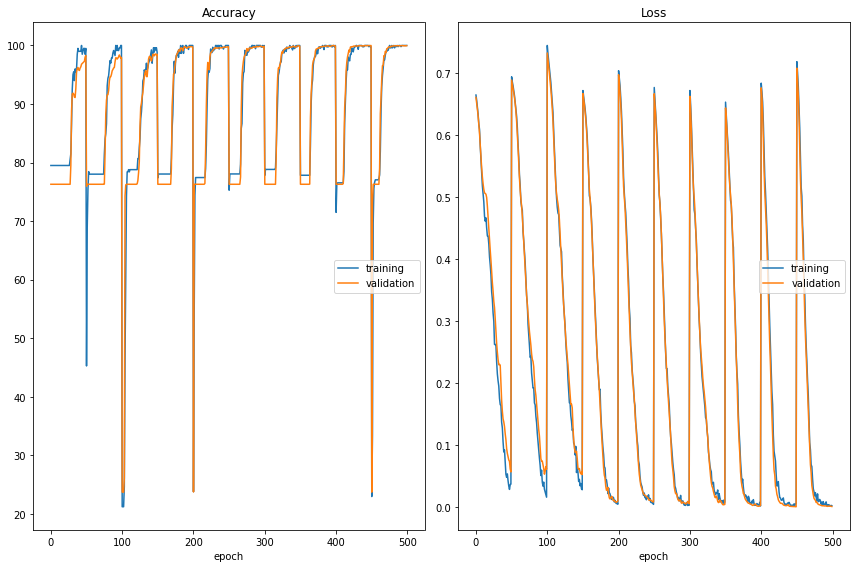

Accuracy
	training         	 (min:   21.212, max:  100.000, cur:  100.000)
	validation       	 (min:   23.708, max:   99.993, cur:   99.966)
Loss
	training         	 (min:    0.002, max:    0.745, cur:    0.002)
	validation       	 (min:    0.001, max:    0.733, cur:    0.001)
Finished Training


In [22]:
clf2,_,_ = train_AL(train_loader, select_loader, device, args, test_loader, from_scratch = True, clf_type = 'NN',\
                    sel_method = 'random')

In [23]:
clf_criterion = nn.BCELoss()
print("test performances")
test_groupwise(clf2,test_loader, clf_criterion, device,args)
print(test_model(clf2, test_loader, clf_criterion, device))

test performances
0.0 : loss 0.0004898359766229987 / acc 100.0
1.0 : loss 0.002066251588985324 / acc 99.89705657958984
(tensor(0.0010), tensor(99.9659))
